# Introduction

Atlanta, my hometown, is a highly diverse city with poorly-defined neighborhoods. While the neighborhoods are often defined by road boundaries, they are characterized by a number of other factors. In this project, I will use data from Four Square to examine the fluctuating popularity of restaurants of various kinds and use that information to classify locations into neighborhoods. I will then compare that data with google-assigned neighborhoods and determine if the two classifications are similar. 

There are a number of possible uses for this neighborhood clustering information, from consumers who would like to know where to go for a particular cuisine, to developers looking to fit a new restaurant into the neighborhood. Additionally, this information could be used by city planning officials in the permitting process.

# Data

This project will utilize data from 2 sources:
1. Trending restaurant data from Foursquare. This will be pulled between 6-7 PM on a Friday (peak restaurant selection time) and saved to a file, since repeated calls to the Foursquare API would result in different trending information. An extension of this project could be to examine the fluctuation of neighborhood boundaries over the course of a week, but that is beyond the scope of this project. 
2. Neighborhood Planning Unit data from The City of Atlanta's GIS database. Accessed through this URL: https://dcp-coaplangis.opendata.arcgis.com/datasets/npu/geoservice The city provides an API to interact with the GIS data, which I will use to extract the geometric boundaries of each neighborhood. The output of this call contains the following information: 
     
     "attributes": {
            "OBJECTID": 260,
            "LOCALID": null,
            "NAME": "K",
            "GEOTYPE": "NPU",
            "FULLFIPS": null,
            "LEGALAREA": null,
            "ACRES": 1528.29,
            "SQMILES": 2.39,
            "OLDNAME": null,
            "NPU": null
         },
         "geometry": {
            "rings": [
               [
                  [
                     -84.4173772073577,
                     33.772197013770004
                  ],
                  
The "Name" attribute is the neighborhood planning unit name, a proxy for a traditional neighborhood name like "midtown". The geometry information will be used to build a boundary box, and each trending restaurant will be placed within those boundaries and classified. 

# Initializations

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium
import folium
import requests
from pandas.io.json import json_normalize

# Methodology
## Connecting with the City of Atlanta's GIS system

## Connect with Foursquare

In this hidden cell, the authorization criteria are provided for interacting with the Foursquare API.

In [10]:
# @hidden_cell
client_secret = 'PLV5C4EDNBSRH4AMBKOXNGHFZWHEWCGULGTQLPQZVQFJFYZO'
client_id = 'HE3V0C15YMFATHFBWRAZ0B32H12HYYSJ1HJ523U02CKPEO3M'
ver = '20180604'

In order to query the foursquare API, we have to specify a latitude, longitude, row limit, and radius in order to create the request URL.

In [17]:
lat = 33.755845
long = -84.38901
limit = 500
radius=500

In [18]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&limit={}&radius={}'.format(client_id, client_secret, lat, long, ver, limit,radius)

Using this URL, we interact with Foursquare and then process the results into a dataframe.

In [13]:
results = requests.get(url).json()
items = results['response']['groups'][0]['items']
dataframe = json_normalize(items)

Within this dataframe, the "Categories" column contains structured data, so we will define a function that extracts the category from this structure.

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

The results dataframe contains much more data than needed for this analysis, so we will create a smaller dataframe with only the information of interest.

In [15]:
data=pd.DataFrame()
data['name'] = dataframe['venue.name']
data['categories'] = dataframe['venue.categories']
data['latitude'] = dataframe['venue.location.lat']
data['longitude'] = dataframe['venue.location.lng']
data['neighborhood'] = dataframe['venue.location.neighborhood']
data['categories'] = data.apply(get_category_type, axis=1)

In [16]:
data.head()

,name,categories,latitude,longitude,neighborhood
0,Fish Bowl Poké,Poke Place,33.755727,-84.389400,"Downtown Atlanta, Atlanta, GA"
1,Blossom Tree,Korean Restaurant,33.755496,-84.389006,NaN
2,Dua Vietnamese Noodle Soup,Vietnamese Restaurant,33.755610,-84.389530,NaN
3,Reuben's Deli,Deli / Bodega,33.755687,-84.389442,NaN
4,Anatolia Cafe & Hookah Lounge,Hookah Bar,33.755120,-84.389413,NaN


## Classify each restaurant into a neighborhood planning unit

# Clustering Analysis
## Visualize Raw Data

In [19]:
venues_map = folium.Map(location=[lat, long], zoom_start=15)

for index, row in data.iterrows():
    lat = row['latitude']
    long = row['longitude']
    label = row['name']
    category = row['categories']
    
    folium.Circle(
        [lat, long],
        popup=label,
        radius=10,
        fill=True
        ).add_to(venues_map)

# display map
venues_map

## Perform clustering analysis on restaurant data

### Convert neighborhood strings into dummy variables
We will use the label encoder function from SKlearn to create an integer representing each given neighborhood.

In [29]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = data['neighborhood'].to_list()
neighborhood_labels = le.fit_transform(y)
data['neighborhood'] = neighborhood_labels
data.head()

,name,categories,latitude,longitude,neighborhood
0,Fish Bowl Poké,Poke Place,33.755727,-84.389400,2
1,Blossom Tree,Korean Restaurant,33.755496,-84.389006,3
2,Dua Vietnamese Noodle Soup,Vietnamese Restaurant,33.755610,-84.389530,3
3,Reuben's Deli,Deli / Bodega,33.755687,-84.389442,3
4,Anatolia Cafe & Hookah Lounge,Hookah Bar,33.755120,-84.389413,3


### Cross Validation Tuning

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/pyth

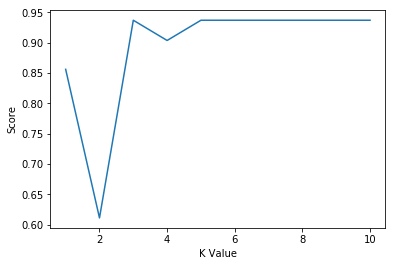

In [49]:
from sklearn.model_selection import cross_val_score
neighbors = list(range(1,11,1))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
plt.plot(neighbors, cv_scores)
plt.xlabel('K Value')
plt.ylabel('Score')
plt.show()

### Perform K Nearest Neighbors Classification with the optimal number of clusters.
We will use the graph above to select the best k value

In [51]:
k = 5
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print(knn.score(X_test,y_test, pred))
print(pred)

0.9411764705882353
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


## Compare results of analysis to City of Atlanta Neighborhood data